# Captum usage example using fastai, pytorch frameworks (last update 24.04.2023)


In [1]:
# captum tcav schauen
# 
# genau die algs je person zuteilen, pro person 
# vortrainiertes model laden -> max 2 ? 
# draw io gui sketch
# Algoaufteilung
# verschiedene modelle laden


In [2]:
# download preptrained model and dataset
# also overrides when if downloaded again
import os
if not os.path.exists("oxford-iiit-pet.zip"):
  os.system('curl -O https://dlcv2023.s3.eu-north-1.amazonaws.com/oxford-iiit-pet.zip')
if not os.path.exists("resnet18_finetuned.pkl"):
  os.system('curl -O https://dlcv2023.s3.eu-north-1.amazonaws.com/resnet18_finetuned.pkl')

In [3]:
# install needed dependancies
%%capture
%%bash
#pip install fastai2
# install captum from repo
git clone https://github.com/tendermonster/captum.git
pip install captum/ fastai2 psutil

In [4]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from fastai.vision.all import PILImage, load_learner, untar_data, get_image_files, ImageDataLoaders, ClassificationInterpretation, Resize, cnn_learner, URLs, resnet18, error_rate

In [5]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [6]:
# we use as a example the pets dataset
if not os.path.exists("./oxford-iiit-pet"):
  os.system('unzip -o oxford-iiit-pet.zip')

In [7]:
# import dataset dataset contains dogs and cats
path = './oxford-iiit-pet/images'
imgs = get_image_files(path)

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, imgs, valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

In [8]:
import os
if not os.path.exists("./resnet18_finetuned.pkl"):
  # if file does not exist finetune resnet18 on the dataset
  # finetune the model on the PETS dataset
  learn = cnn_learner(dls, resnet18, metrics=error_rate)
  learn.fine_tune(epochs=1)
  # Basic interpertation of the model prediected classes vs. actual ones.
  interp = ClassificationInterpretation.from_learner(learn)
  # Visualize top losses, e.g. to check if the images themselves are correctly annotated.
  interp.plot_confusion_matrix()
  interp.plot_top_losses(5, nrows=1)
  # save the model
  learn.export('./resnet18_finetuned.pkl')
else:
  # load the model
  learn_inf = load_learner(cpu=False, fname='./resnet18_finetuned.pkl')

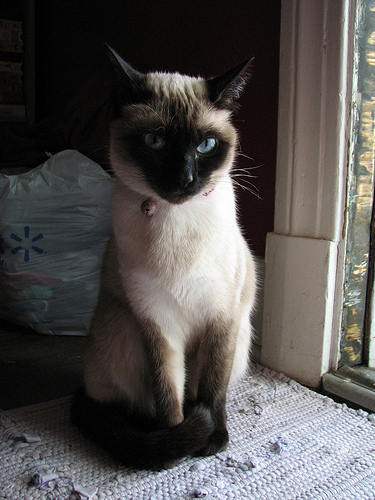

In [9]:
# get random image
import random
idx = random.randint(0, len(imgs))
# cute
image = PILImage.create(imgs[idx])
image

In [10]:
#convert to tensorimage
image = learn_inf.dls.after_item(image)
image = learn_inf.dls.after_batch(image.cuda())

In [11]:
pred,pred_idx,probs = learn_inf.predict(imgs[idx])
pred, pred_idx, probs

('True', tensor(1), tensor([4.9925e-12, 1.0000e+00]))

In [12]:
transposed_image = np.transpose(image.squeeze().cpu().numpy(), (1,2,0))

## Interpretability
Let's use Captum.ai to interpret the model predictions and to have a visual on where the network focused more in the input image.

### Gradient-based attribution
Integrated Gradients is an interpretaility technique based on the approximation of integral gradients. The basic implementation works as followss:
* Given as input target image and a baseline image (usually a black image), generate multiple images between both starting from darker to lighter.
* Do forward pass with each of those images to predict a class and calculate the gradient.
* Approximate the integral of the gradients of all those images

The following example, illustrates how to use Captum `IntegratedGradients` to compute the attributions using Integrated Gradients and visualize them on the target image.

In [13]:
integrated_gradients = IntegratedGradients(learn_inf.model)
attr_ig = integrated_gradients.attribute(image, target=pred_idx, n_steps=200)

In [14]:
transposed_attr_ig = np.transpose(attr_ig.squeeze().cpu().numpy(), (1,2,0))

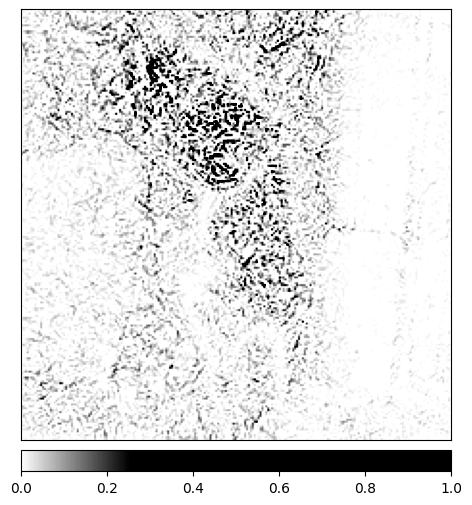

In [15]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(transposed_attr_ig,
                             transposed_image,
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=2)

### Occlusion-based attribution
Occlusion-based attribution is a different interepretation technique based on perturbing parts of the original image (e.g. by zeroing) and computing how this affects the model decision.
This technique is implemented by:
* Slide a window of shape (h, w) on the target image with a stride s
* Replace the window with a baseline (e.g. with black) and qunatify the effect on model decision.
* Repeat previous steps until all of the target image is covered. 

Simiarly to convolution, this technique can become very slow when used in large models and large input images.

As a first exercise, we run a sliding window of size 15x15 and a stride of 8 along both image dimensions. For each window, we occlude the image with a baseline value of 0.

In [16]:
occlusion = Occlusion(learn_inf.model)

attr_occ = occlusion.attribute(image,
                               strides = (3, 4, 4),
                               target=pred_idx,
                               sliding_window_shapes=(3,6, 6),
                               baselines=0)

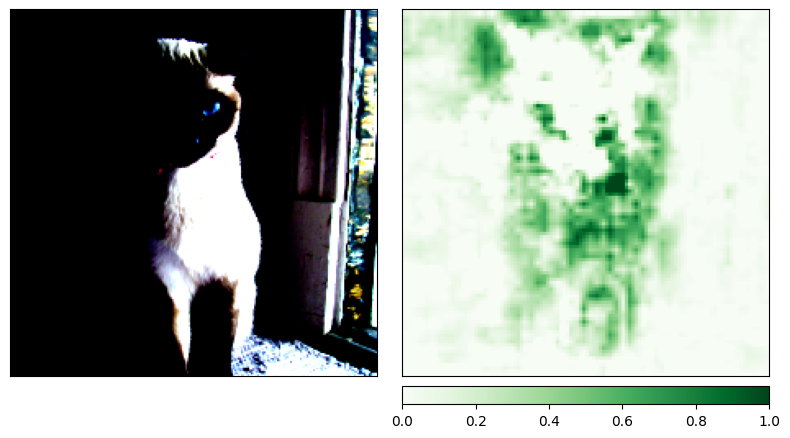

In [17]:
_ = viz.visualize_image_attr_multiple(np.transpose(attr_occ.squeeze().cpu().numpy(), (1,2,0)),
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

Let's try different window shape and sliding window and visuzalize the result, by rescaling back to the shape of the original image.

Experimenting with different windows is important because:
* Different shape may lead to a significaly different result.
* Larger windows is useful when the input image presents some local coherence.


## Saliency

In [18]:
# Defining Saliency interpreter
saliency = Saliency(learn_inf.model)
# Computes saliency maps for class 3.
attribution = saliency.attribute(image, target=0)

/usr/local/lib/python3.9/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [19]:
transposed_image.shape

(224, 224, 3)

In [20]:
np.transpose(attribution.squeeze().cpu().numpy(), (1,2,0)).shape

(224, 224, 3)

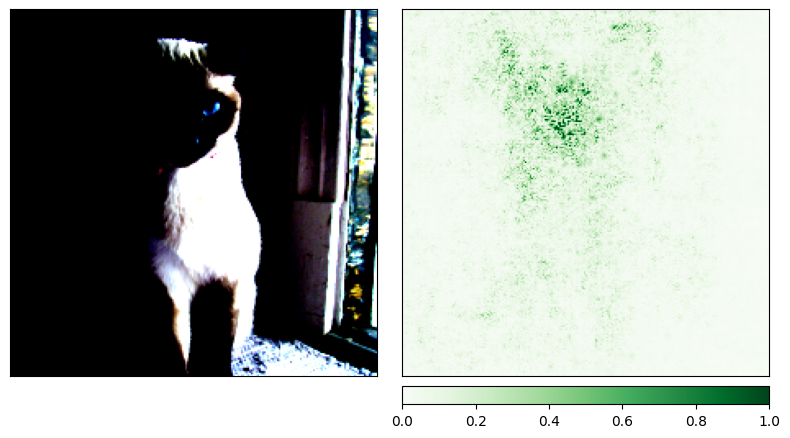

In [21]:
_ = viz.visualize_image_attr_multiple(np.transpose(attribution.squeeze().cpu().numpy(), (1,2,0)),
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

# Using a custom model from a deep learning framework mmyolo to show that models other than pytorch do not really work effortlessly

In [22]:
%%capture
%%bash
pip install mmengine
pip install torchvision

In [23]:
import torch

In [24]:
if not os.path.exists("./yolov5_demo_cat_od.pth"):
  os.system("curl -O https://dlcv2023.s3.eu-north-1.amazonaws.com/yolov5_demo_cat_od.pth") # download the model 
# ! curl -o # download the cat dataset it was trained on 

In [25]:
# check if pytorch can import model from different framework
try:
  # if we are lucky and the model was saved using torch.save() than it might work
  model = torch.load("yolov5_demo_cat_od.pth")
  type(model)
  model.eval()
  # but usually it will fail
  print("Model has need loaded succesfully by torch")
except Exception:
  print("non pytorch model cannot be loaded by pytorch usually")

non pytorch model cannot be loaded by pytorch usually


In [26]:
# check of captum can import model from different framework other then pytorch natively?
# because we cannot import model in pytorch we naturally have no way of using the model in captum :D
# p.s o have no idea how to write forward_func for captum to work 

In [27]:
# type(learn_inf.model) -> torch.nn.modules.container.Sequential -> fastai conviniently provides with pytorch model
# we see that fastai model is working correctly
try:
  learn_inf.model.eval()
  print("Model is torch model")
except Exception:
  print("model is not torch model!")

Model is torch model


# Importing custom model writen in pytorch


In [28]:
if not os.path.exists("./SimpleDLA_10epochs_cifar10.pth"):
  os.system("curl -O https://dlcv2023.s3.eu-north-1.amazonaws.com/SimpleDLA_10epochs_cifar10.pth")

consult: https://pytorch.org/tutorials/beginner/saving_loading_models.html

soooo the cooking recipie is as fallows

In [29]:
# to correctly import the model it is recommended to place the model.py into the 
# directory and import it
if not os.path.exists("./pytorch_cifar"):
  os.system("git clone https://github.com/kuangliu/pytorch-cifar")
  os.system("mv pytorch-cifar ./pytorch_cifar")

In [30]:
# we need select the model that we are importing 
# this part needs to be writen custom to accomidate the model that needs to be tested
import torch.backends.cudnn as cudnn 
from pytorch_cifar.models import SimpleDLA

#prepare model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleDLA()
model = model.to(device)
if device == "cuda":
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

model_load = torch.load("SimpleDLA_10epochs_cifar10.pth")
print(model_load.keys())
model.load_state_dict(model_load['net'])
best_acc = model_load['acc']
start_epoch = model_load['epoch']
model.eval()

# testing if the pytorch model has been loaded
try:
  # todo do some checks if file exists or so
  model_load = torch.load("SimpleDLA_10epochs_cifar10.pth")
  model.load_state_dict(model_load['net'])
  model.eval()
  print("Model has need loaded succesfully by torch")
except Exception:
  print("non pytorch model cannot be loaded by pytorch usually")

dict_keys(['net', 'acc', 'epoch'])
Model has need loaded succesfully by torch


## Lets try to run some captum attributions

In [31]:
# download the cifar10 dataset and prepate the date to be inputed into the model
import torchvision
import torchvision.transforms as transforms

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)
if not os.path.exists("./data"):
  testset = torchvision.datasets.CIFAR10(
      root="./data", train=False, download=True, transform=transform_test)
else:
  testset = torchvision.datasets.CIFAR10(
      root="./data", train=False, download=False, transform=transform_test)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

In [32]:
import random
cifar_inputs = list(testloader)[0][0]
cifar_targers = list(testloader)[0][1]

In [80]:
# get random sample
ind = int(random.random()*len(cifar_inputs))
cifar_in = cifar_inputs[ind]
cifar_in_target = cifar_targers[ind]
# unnormalize
inv_normal = transforms.Compose(
    [
        transforms.Normalize(mean = [ 0., 0., 0. ],
                             std = [ 1/0.2023, 1/0.1994, 1/0.2010]),
     transforms.Normalize(mean = [-0.4914, -0.4822, -0.4465],
                          std = [ 1., 1., 1. ]),
    ]
)

cifar_in_img = inv_normal(cifar_in)

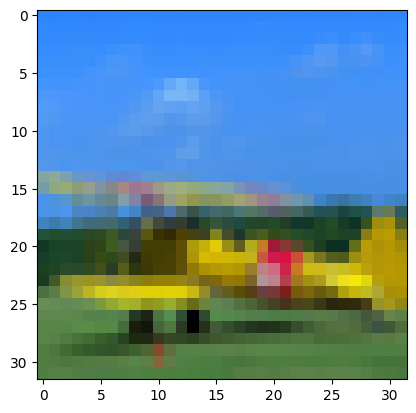

In [81]:
# show the image
import matplotlib.pyplot as plt
plt.imshow(cifar_in_img.permute(1, 2, 0))

In [82]:
# Defining Saliency interpreter
saliency = Saliency(model)
# need to reshape because captum expecting 4d shape
cifar_in = cifar_in.reshape(1, 3, 32, 32)
# Computes saliency maps for class 3.
attribution = saliency.attribute(cifar_in, target=0)

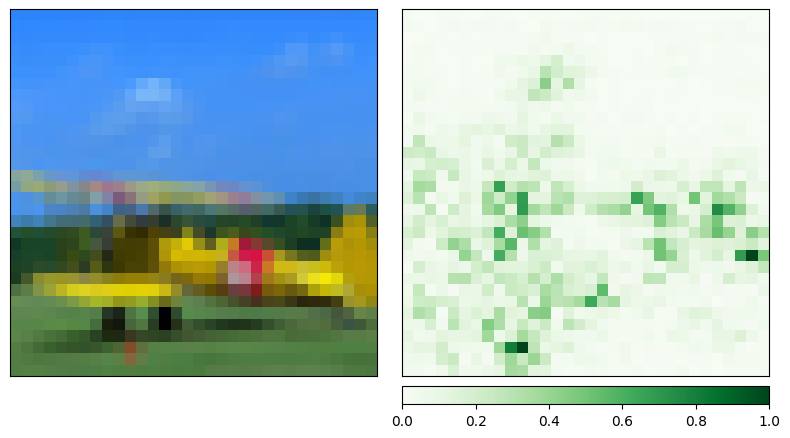

In [83]:
_ = viz.visualize_image_attr_multiple(np.transpose(attribution.squeeze().cpu().numpy(), (1,2,0)),
                                      cifar_in_img.permute(1, 2, 0).numpy(),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [78]:
np.transpose(attribution.squeeze().cpu().numpy(), (1,2,0)).shape

(32, 32, 3)

In [39]:
np.transpose(attribution.squeeze().cpu().numpy(), (1,2,0)).shape

(32, 32, 3)

In [40]:
cifar_in_img.T.numpy().shape

(32, 32, 3)